# Imports


In [1]:
import mido
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
import utils
import shapes
import time
import fitz

In [2]:
f = fitz.open("101000.pdf")
pix = f[0].get_pixmap(dpi=1000, colorspace="GRAY")
img = np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape(
    (pix.height, pix.width, 1)
)

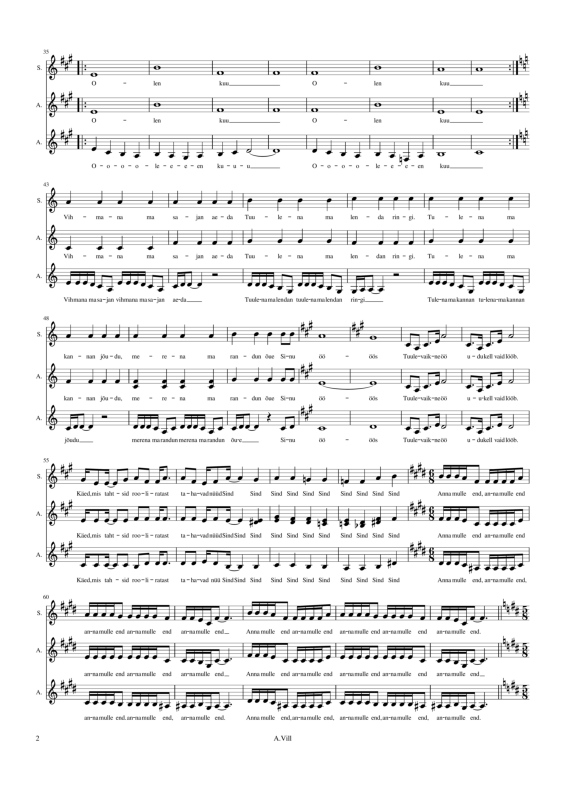

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.imshow(pdf_images[1])
ax.set_axis_off()

# Templates


In [110]:
clef_paths = {"treble": ["../resources/clefs/treble-1.png"]}
clef = {
    "treble": [
        cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2GRAY)
        for filepath in clef_paths["treble"]
    ]
}

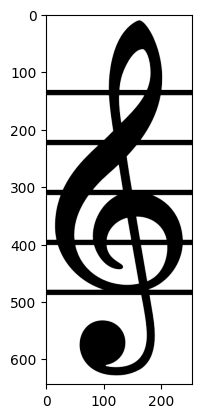

In [10]:
plt.imshow(clef["treble"][0], cmap="Greys_r")

# Staff detection


In [3]:
img = cv2.fastNlMeansDenoising(np.array(pdf_images[1]), 10, 7, 21)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
retval_spacing_width, img = cv2.threshold(
    img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)  # Apply thresholding

KeyboardInterrupt: 

In [6]:
line_spacing, line_width = utils.get_reference_lengths(img)
staff_length = (5 * line_width) + (4 * line_spacing)
all_staff_row_indices = utils.find_staffline_rows(img, line_width, line_spacing)
all_staff_col_indices = utils.find_staffline_columns(
    img, all_staff_row_indices, line_width, line_spacing
)

In [8]:
half_sep = utils.get_staff_separation(all_staff_row_indices, all_staff_col_indices)

In [7]:
len(all_staff_row_indices), len(all_staff_col_indices)

(15, 15)

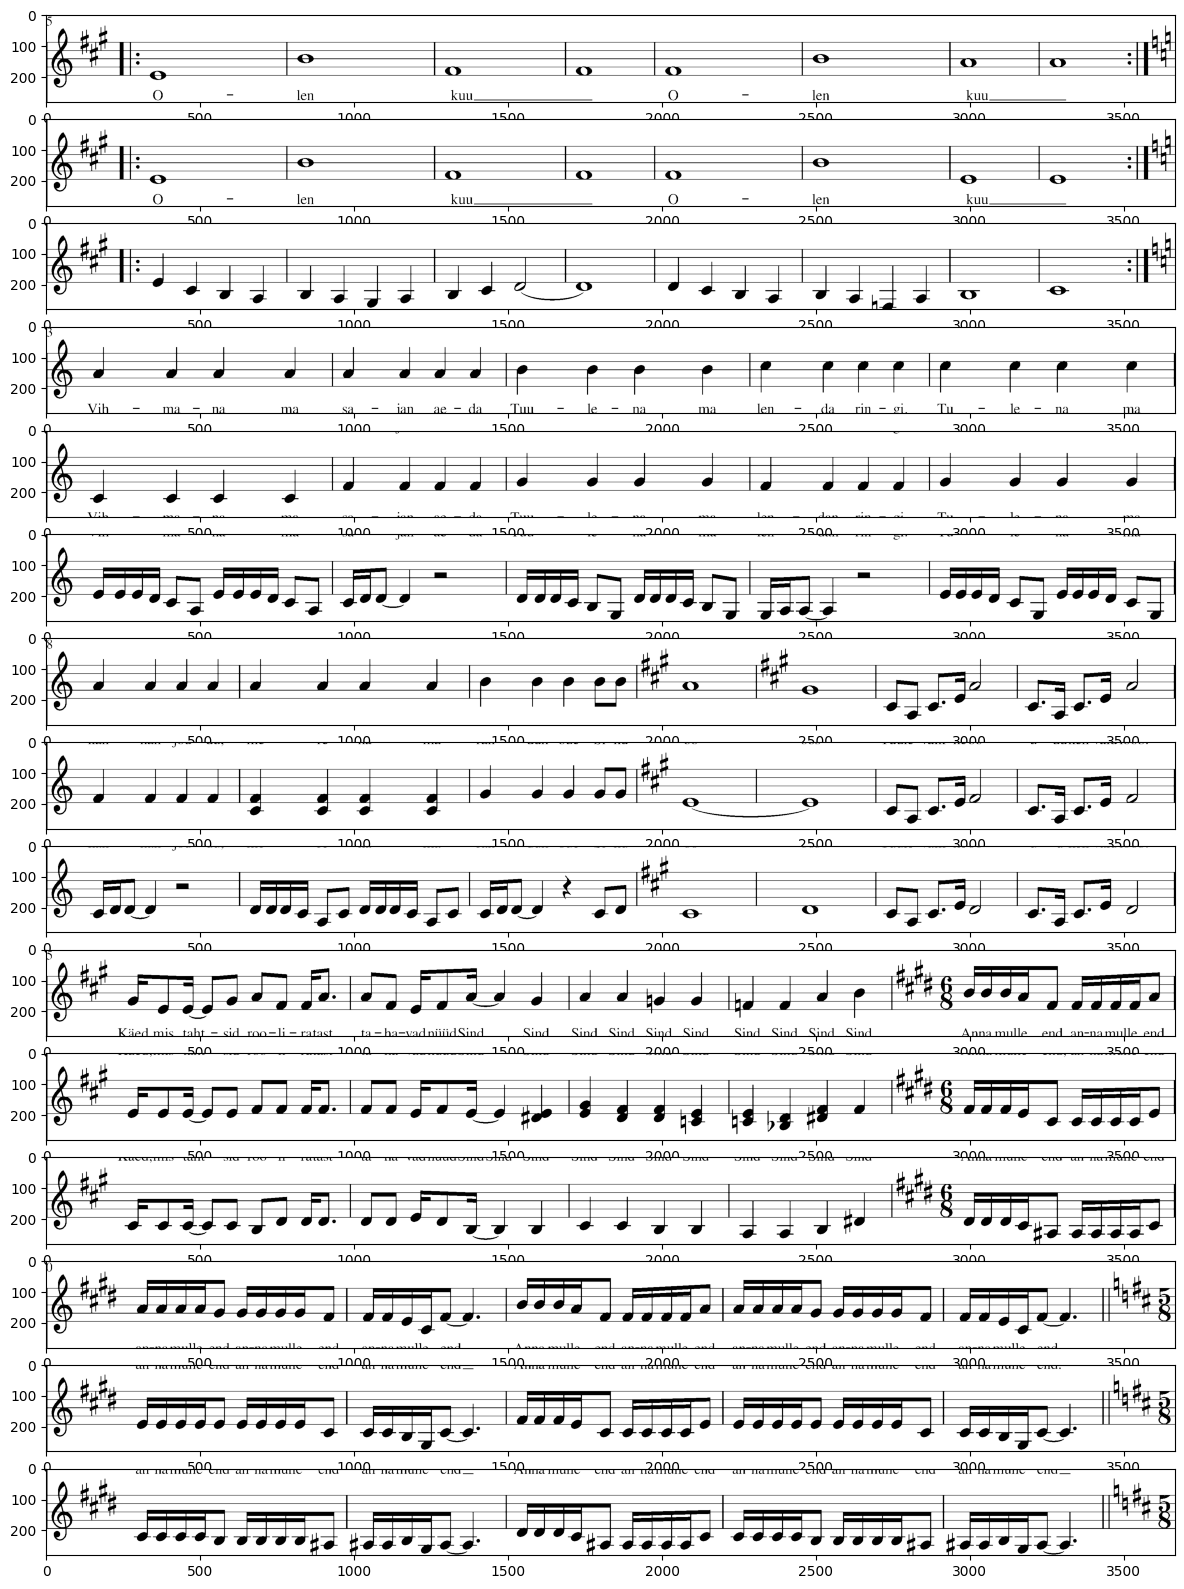

In [15]:
fig, axs = plt.subplots(
    len(all_staff_row_indices), 1, figsize=(40, 20), gridspec_kw={"hspace": 0.2}
)
staffs = []
for i, (row_idx, col_idx) in enumerate(
    zip(all_staff_row_indices, all_staff_col_indices)
):
    x = row_idx[0][0]  # get the first row of the first line, top left corner x
    y = col_idx[0]  # get the first column extreme, top left corner y
    r = row_idx[-1][-1] - x
    c = col_idx[-1] - y
    # adding the half sep as padding
    staff_box = shapes.BoundingBox(
        max(0, x - half_sep), y, min(x + r + half_sep, img.shape[0] - 1) - x, c
    )
    staff_img = img[
        max(0, x - half_sep) : min(x + r + half_sep, img.shape[0] - 1), y : y + c
    ]
    axs[i].imshow(staff_img, cmap="Greys_r")

# Staff chunk detection


In [17]:
np.unique(img)

array([  0, 255], dtype=uint8)

In [42]:
# a chunk will have atleast 2 staves
# so 5 * 2 lines
# 4 * 2 spaces
# basically 2 staff length
# 2 * half_seps


def get_chunks(img, staff_length, half_sep):
    min_chunk_length = 2 * (staff_length + half_sep)
    num_rows = img.shape[0]
    num_cols = img.shape[1]
    binary_image = (img == 0).astype(int)
    chunks = []
    for col in range(num_cols):
        col_data = binary_image[:, col]
        run_starts = np.where(np.diff(col_data) == 1)[0] + 1
        run_ends = np.where(np.diff(col_data) == -1)[0]
        if col_data[0] == 1:
            run_starts = np.insert(run_starts, 0, 0)
        if col_data[-1] == 1:
            run_ends = np.append(run_ends, num_rows - 1)
        run_lengths = run_ends - run_starts + 1
        valid_runs = np.where(run_lengths >= min_chunk_length)[0]
        for idx in valid_runs:
            chunks.append([run_starts[idx], run_ends[idx]])

    return list(set(map(tuple, chunks)))


chunks = get_chunks(img, staff_length, half_sep)

In [55]:
list(set(map(tuple, chunks)))

[(2408, 3152), (4525, 5235), (1392, 2072), (3487, 4189), (384, 1056)]

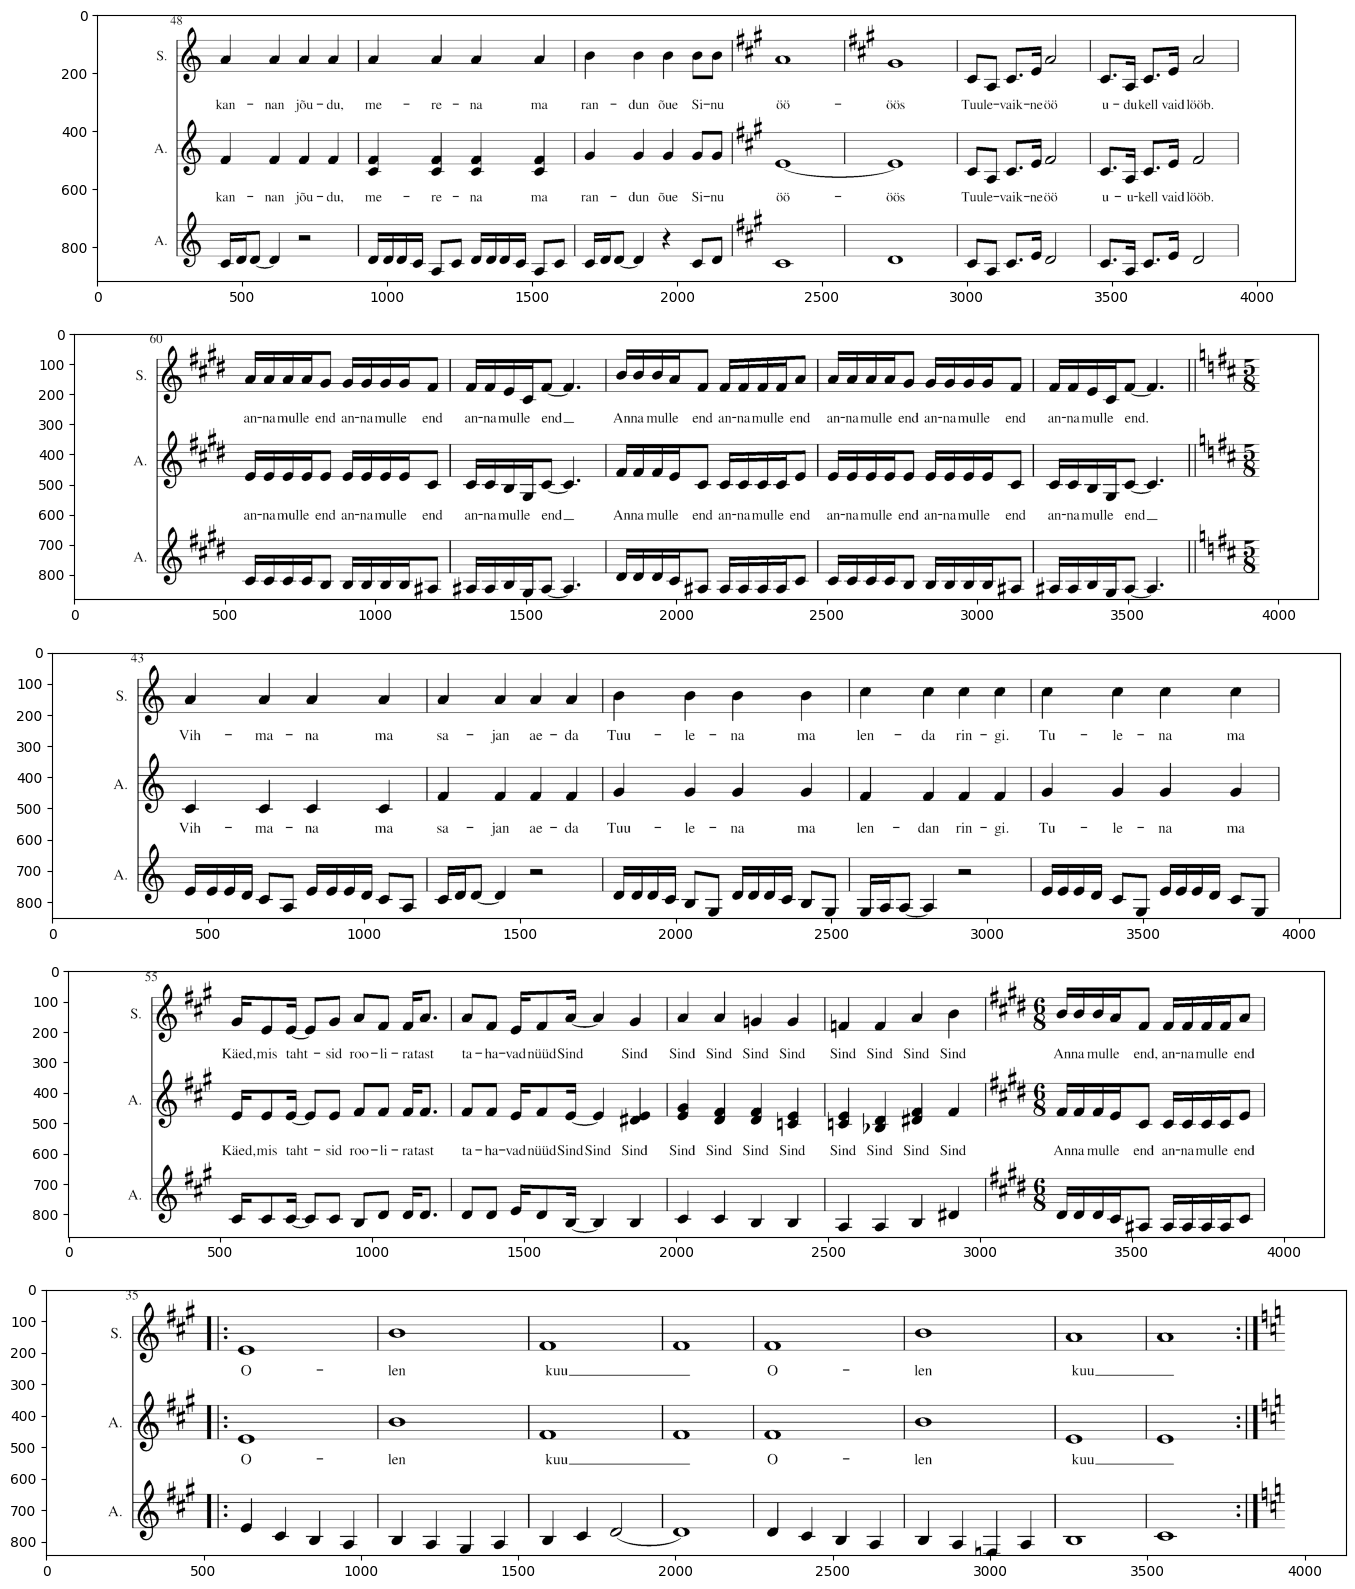

In [57]:
fix, axs = plt.subplots(len(list(set(map(tuple, chunks)))), 1, figsize=(40, 20))
for ax, ch in zip(axs, list(set(map(tuple, chunks)))):
    ax.imshow(img[ch[0] - half_sep : ch[1] + half_sep, :], cmap="Greys_r")

# classes


In [3]:
def format_time(start, current):
    elapsed = current - start
    seconds = int(elapsed)
    microseconds = int((elapsed - seconds) * 1e2)
    return f"{seconds} s : {microseconds} ms"


def print_log(msg, start):
    checkpoint = time.time()
    print(f"{msg:5s} {format_time(start, checkpoint)}")

In [7]:
class Sheet:
    """
    Class to store every sheet of the input
    """

    def __init__(self, img) -> None:
        # base image
        start = time.time()
        # img = cv2.fastNlMeansDenoising(np.array(img), 10, 7, 21)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        self.img = img
        print_log("[IMAGE IMPORTED]", start)
        start = time.time()

        # image properties, lengths and indices
        self.line_spacing, self.line_width = utils.get_reference_lengths(self.img)
        print_log("[COMPUTED REF LENGTHS]", start)
        start = time.time()

        self.staff_length = (5 * self.line_width) + (4 * self.line_spacing)
        self.all_staff_row_indices = utils.find_staffline_rows(
            self.img, self.line_width, self.line_spacing
        )
        print_log("[COMPUTED STAFF ROWS]", start)
        print(len(self.all_staff_row_indices))
        start = time.time()
        self.all_staff_col_indices = utils.find_staffline_columns(
            self.img, self.all_staff_row_indices, self.staff_length
        )
        print_log("[COMPUTED STAFF COLUMNS]", start)
        print(len(self.all_staff_col_indices))
        start = time.time()
        self.half_sep = utils.get_staff_separation(
            self.all_staff_row_indices, self.staff_length
        )
        print_log("[COMPUTED STAFF SEPARATION]", start)
        start = time.time()
        chunk_indices = utils.get_chunks(self.img, self.staff_length, self.half_sep)
        self.all_chunk_indices = sorted(chunk_indices, key=lambda x: x[1])
        print_log("[COMPUTED CHUNK INDICES]", start)
        print(self.all_chunk_indices)
        start = time.time()
        self.chunks = self._get_chunks_list()
        print_log("[COMPUTED CHUNK LIST]", start)
        print(len(self.chunks))
        start = time.time()
        self.staff_boxes = self._get_staves_list()
        print_log("[COMPUTED STAFF LIST]", start)

    def _get_chunks_list(self):
        chunks = []
        row_extremes = [[r[0][0], r[-1][-1]] for r in self.all_staff_row_indices]
        i = 0
        for chunk_start, chunk_end in self.all_chunk_indices:
            rows_in_chunk = []
            iter_range = range(i, len(row_extremes))
            for i in iter_range:
                row_start, row_end = row_extremes[i]
                if (
                    chunk_start - self.line_spacing <= row_start
                    and row_end <= chunk_end + self.line_spacing
                ):
                    rows_in_chunk.append(i)
                else:
                    break
            chunks.append(rows_in_chunk)
        return chunks

    def _get_staves_list(self):
        staff_boxes = []
        for row_idx, col_idx in zip(
            self.all_staff_row_indices, self.all_staff_col_indices
        ):
            x = row_idx[0][0]  # get the first row of the first line, top left corner x
            y = col_idx[0]  # get the first column extreme, top left corner y
            r = row_idx[-1][-1] - x
            c = col_idx[-1] - y
            # adding the half sep as padding
            staff_box = shapes.BoundingBox(
                max(0, x - self.half_sep),
                y,
                min(x + r + 2 * self.half_sep, self.img.shape[0] - 1) - x,
                c,
            )
            staff_boxes.append(staff_box)
        return staff_boxes

In [ ]:
class Sheet:
    """
    Class to store every sheet of the input
    """

    def __init__(self, img) -> None:
        start = time.time()
        _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        self.img = img
        # print_log("[IMAGE IMPORTED]", start)
        # start = time.time()

        # image properties, lengths and indices
        self.line_spacing, self.line_width = utils.get_reference_lengths(self.img)
        # print_log("[COMPUTED REF LENGTHS]", start)
        # start = time.time()

        self.staff_length = (5 * self.line_width) + (4 * self.line_spacing)
        self.all_staff_row_indices = utils.find_staffline_rows(
            self.img, self.line_width, self.line_spacing
        )
        # print_log("[COMPUTED STAFF ROWS]", start)
        # print(len(self.all_staff_row_indices))
        # start = time.time()
        self.all_staff_col_indices = utils.find_staffline_columns(
            self.img, self.all_staff_row_indices, self.staff_length
        )
        # print_log("[COMPUTED STAFF COLUMNS]", start)
        # print(len(self.all_staff_col_indices))
        # start = time.time()
        self.half_sep = utils.get_staff_separation(
            self.all_staff_row_indices, self.staff_length
        )
        # print_log("[COMPUTED STAFF SEPARATION]", start)
        # start = time.time()
        chunk_indices = utils.get_chunks(self.img, self.staff_length, self.half_sep)
        self.all_chunk_indices = sorted(chunk_indices, key=lambda x: x[1])
        # print_log("[COMPUTED CHUNK INDICES]", start)
        # print(self.all_chunk_indices)
        # start = time.time()
        self.chunks = self._get_chunks_list()
        # print_log("[COMPUTED CHUNK LIST]", start)
        # print(len(self.chunks))
        # start = time.time()
        self.staff_boxes = self._get_staves_list()
        # print_log("[COMPUTED STAFF LIST]", start)

    def _get_chunks_list(self):
        chunks = []
        row_extremes = [[r[0][0], r[-1][-1]] for r in self.all_staff_row_indices]
        i = 0
        for chunk_start, chunk_end in self.all_chunk_indices:
            rows_in_chunk = []
            iter_range = range(i, len(row_extremes))
            for i in iter_range:
                row_start, row_end = row_extremes[i]
                if (
                    chunk_start - self.line_spacing <= row_start
                    and row_end <= chunk_end + self.line_spacing
                ):
                    rows_in_chunk.append(i)
                else:
                    break
            chunks.append(rows_in_chunk)
        return chunks

    def _get_staves_list(self):
        staff_boxes = []
        for row_idx, col_idx in zip(
            self.all_staff_row_indices, self.all_staff_col_indices
        ):
            x = row_idx[0][0]  # get the first row of the first line, top left corner x
            y = col_idx[0]  # get the first column extreme, top left corner y
            r = row_idx[-1][-1] - x
            c = col_idx[-1] - y
            # adding the half sep as padding
            staff_box = shapes.BoundingBox(
                max(0, x - self.half_sep),
                y,
                min(x + r + 2 * self.half_sep, self.img.shape[0] - 1) - x,
                c,
            )
            staff_boxes.append(staff_box)
        return staff_boxes

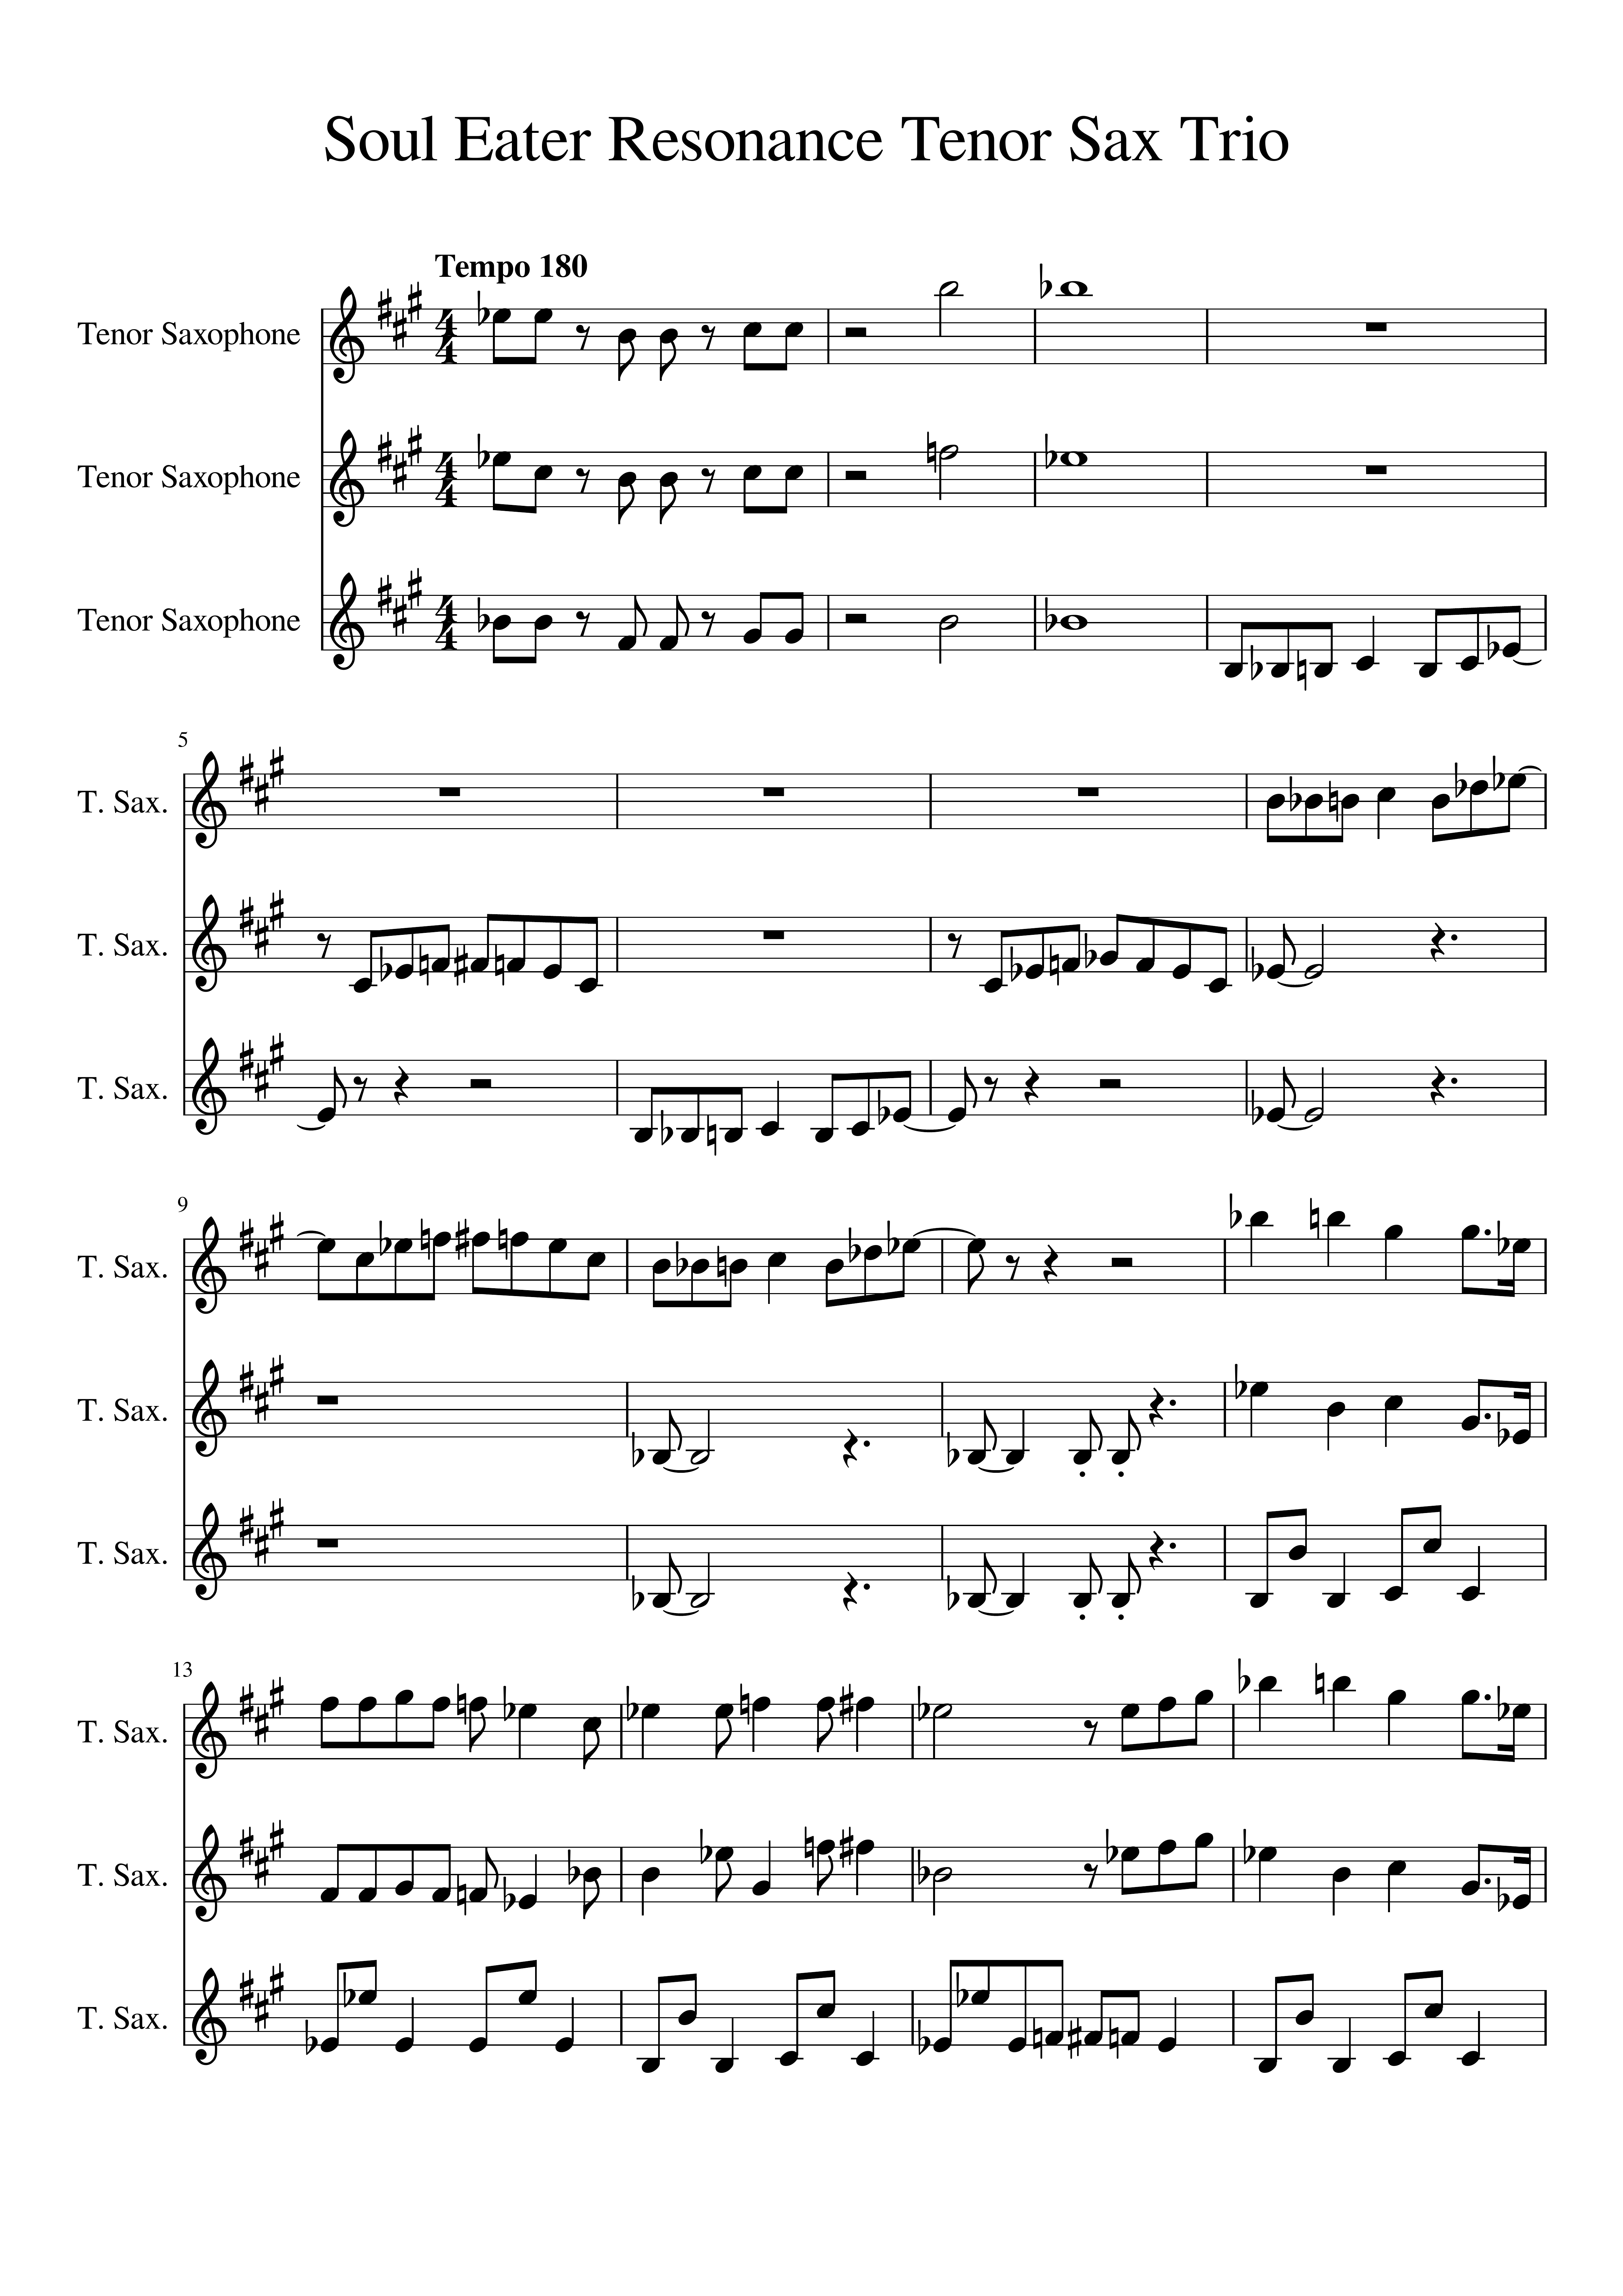

In [9]:
pdf_images[0]

In [8]:
s = Sheet(pdf_images[0])

[IMAGE IMPORTED] 0 s : 13 ms
[COMPUTED REF LENGTHS] 1 s : 18 ms
[COMPUTED STAFF ROWS] 0 s : 13 ms
1
[COMPUTED STAFF COLUMNS] 0 s : 12 ms
1


ValueError: min() arg is an empty sequence

In [6]:
len(s.all_staff_row_indices)

NameError: name 's' is not defined

In [12]:
s.all_chunk_indices

[(675, 1767), (1859, 2951), (3043, 4135), (4228, 5320)]

In [13]:
len(s.chunks)

4

In [14]:
s.chunks

[[0, 1, 2], [3, 4, 5], [6, 7], [8, 9, 10]]

In [ ]:
fig, axs = 

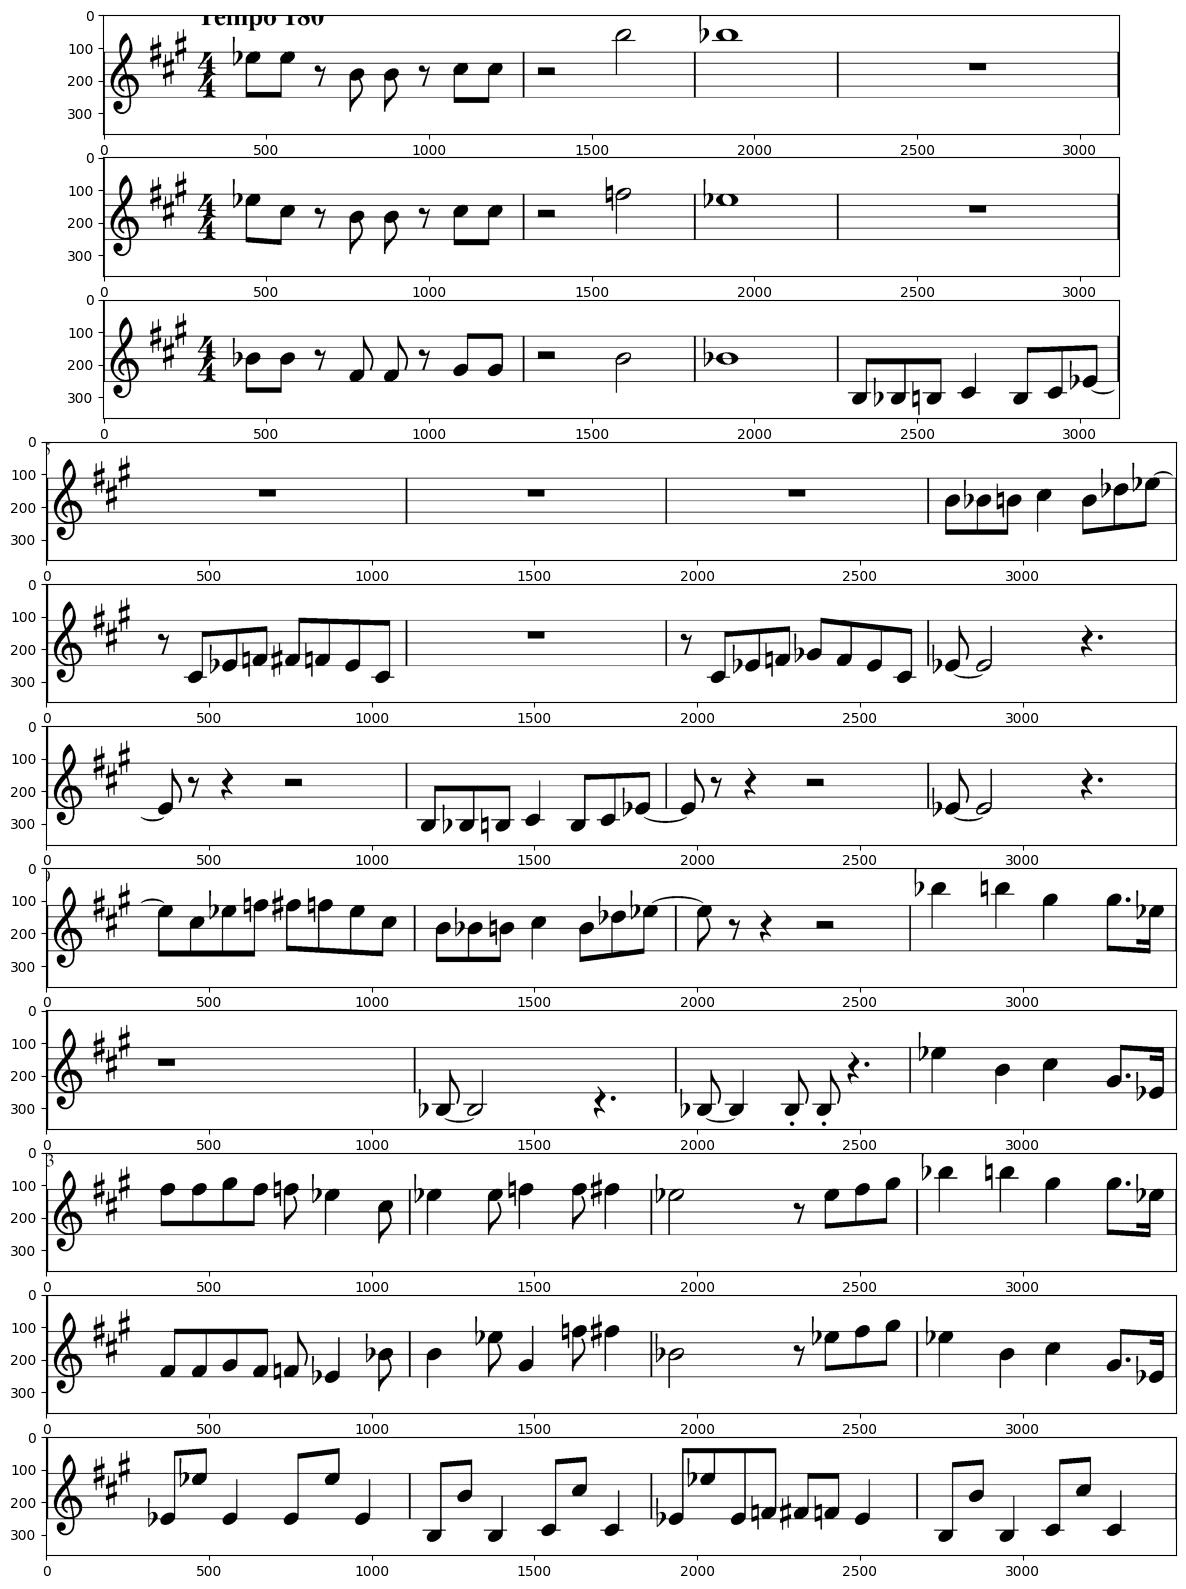

In [15]:
fig, axs = plt.subplots(len(s.all_staff_row_indices), 1, figsize=(40, 20))
for ax, box in zip(axs, s.staff_boxes):
    ax.imshow(box.crop(s.img), cmap="Greys_r")

# efficient code for reference lengths


In [22]:
383 - s.half_sep, 1500 + s.half_sep

(297, 1586)

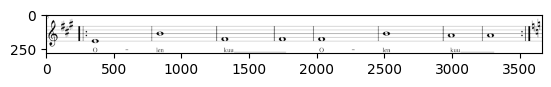

In [19]:
plt.figsize = (20, 10)
plt.imshow(s.staff_boxes[0].crop(s.img), cmap="Greys_r")

In [45]:
img = s.img[297:1586, 500]

In [37]:
num_rows = img.shape[0]  # Image Height (number of rows)
num_cols = img.shape[1]  # Image Width (number of columns)
rle_image_white_runs = []  # Cumulative white run list
rle_image_black_runs = []  # Cumulative black run list
sum_all_consec_runs = []  # Cumulative consecutive black white runs

In [28]:
runs = []
white_runs = []
black_runs = []
run_val = 0
run_type = img[0]

for j in range(len(img)):
    if img[j] == run_type:
        run_val += 1
    else:
        runs.append(run_val)
        if run_type == 0:
            black_runs.append(run_val)
        else:
            white_runs.append(run_val)
        run_type = img[j]
        run_val += 1
runs.append(run_val)
if run_type == 0:
    black_runs.append(run_val)
else:
    white_runs.append(run_val)

In [32]:
s.line_spacing

25

In [30]:
img

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [34]:
np.diff(runs)

array([  2,  25,   2,  24,   3,  24,   2,  25,   2, 173,   2,  25,   2,
        24,   3,  24,   2,  25,   2, 173,   2,  24,   3,  24,   2,  25,
         2,  25,   2, 335,   2,  25,   2,  24,   3,  24,   2,  25,   2,
        85])

In [11]:
Counter(black_runs).most_common()

[(12, 1), (19, 1), (26, 1), (33, 1), (40, 1)]

In [10]:
white_runs

[10, 17, 24, 31, 38, 50]

In [50]:
utils.get_reference_lengths(s.img)

(25, 2)

In [63]:
def get_reference_lengths(img):
    retval_spacing_width = []
    for pixel_value in [255, 0]:
        pixels = np.where(img == pixel_value, 1, 0)
        flat = np.ravel(pixels, "F")
        run_starts = np.where(np.diff(flat) == 1)[0] + 1
        run_ends = np.where(np.diff(flat) == -1)[0]
        if flat[0] == 1:
            run_starts = np.insert(run_starts, 0, 0)
        if flat[-1] == 1:
            run_ends = np.append(run_ends, len(flat) - 1)
        run_lengths = run_ends - run_starts + 1
        run_counter = Counter(run_lengths)
        retval_spacing_width.append(run_counter.most_common(1)[0][0])

    return retval_spacing_width


get_reference_lengths(s.img)

[25, 2]

In [67]:
((3 - 0.9) / 3) * 100

70.0

# efficient code for row indices


In [85]:
utils.find_staffline_rows(s.img, s.line_width, s.line_spacing)

[[[383, 384], [410, 411], [437, 438], [464, 465], [491, 492]],
 [[665, 666], [692, 693], [719, 720], [746, 747], [773, 774]],
 [[947, 948], [974, 975], [1001, 1002], [1028, 1029], [1055, 1056]],
 [[1391, 1392], [1418, 1419], [1445, 1446], [1472, 1473], [1499, 1500]],
 [[1673, 1674], [1700, 1701], [1727, 1728], [1754, 1755], [1781, 1782]],
 [[1963, 1964], [1990, 1991], [2017, 2018], [2044, 2045], [2071, 2072]],
 [[2407, 2408], [2434, 2435], [2461, 2462], [2488, 2489], [2515, 2516]],
 [[2725, 2726], [2752, 2753], [2779, 2780], [2806, 2807], [2833, 2834]],
 [[3042, 3043], [3069, 3070], [3096, 3097], [3123, 3124], [3150, 3151]],
 [[3486, 3487], [3513, 3514], [3540, 3541], [3567, 3568], [3594, 3595]],
 [[3768, 3769], [3795, 3796], [3822, 3823], [3849, 3850], [3876, 3877]],
 [[4080, 4081], [4107, 4108], [4134, 4135], [4161, 4162], [4188, 4189]],
 [[4524, 4525], [4551, 4552], [4578, 4579], [4605, 4606], [4632, 4633]],
 [[4806, 4807], [4833, 4834], [4860, 4861], [4887, 4888], [4914, 4915]],
 [

In [115]:
def find_staffline_rows(img, line_width, line_spacing):
    num_rows = img.shape[0]  # Image Height (number of rows)
    num_cols = img.shape[1]  # Image Width (number of columns)

    # Determine number of black pixels in each row
    # before that convert the image to a binary one again
    binary_image = np.where(img == 0, 1, 0)
    row_black_pixel_sum = np.sum(binary_image, axis=1)

    all_staff_row_indices = []
    num_stafflines = 5
    threshold = 0.3

    # Note that previous code considered ALL rows as candidates to have a staff line
    # Here we take a strict set of candidates which have a certain required number of black pixels
    # Problem with this is that this will one of the rows of the staff line
    # So take a lenient set of candidates which is 1 line width before and after this
    # Looping will ensure all the necessary rows are picked
    strict_candidates = np.where(row_black_pixel_sum > 0.7 * num_cols)[0]
    candidates = np.sort(
        np.unique(
            np.concatenate(
                [
                    strict_candidates + k
                    for k in range(-line_width, line_width + 1, 2 * line_width)
                ]
            )
        ),
        kind="quicksort",
    )

    # Find stafflines by finding sum of rows that occur according to
    # staffline width and staffline space which contain as many black pixels
    # as a thresholded value (based of width of page)
    #
    # Filter out using condition that all lines in staff
    # should be above a threshold of black pixels
    for current_row in candidates:
        indices = [
            list(range(j, j + line_width))
            for j in range(
                current_row,
                current_row + (num_stafflines - 1) * (line_width + line_spacing) + 1,
                line_width + line_spacing,
            )
        ]
        staff_lines = row_black_pixel_sum[indices]

        for line in staff_lines:
            if sum(line) / line_width < threshold * num_cols:
                current_row += 1
                break
        else:
            staff_row_indices = indices
            all_staff_row_indices.append(staff_row_indices)

    extremes = np.array([[_[0][0], _[-1][-1]] for _ in all_staff_row_indices])
    extremes_flat = np.ravel(extremes)
    diff = np.diff(extremes_flat)
    coords = (np.where(diff < 0)[0] + 1) // 2
    # for c in coords:
    #     a = np.array(all_staff_row_indices[c - 1])
    #     b = np.array(all_staff_row_indices[c])
    #     all_staff_row_indices[c - 1] = np.unique(
    #         np.concatenate([a, b]), axis=0
    #     ).tolist()

    for c in coords[::-1]:
        _ = all_staff_row_indices.pop(c)

    return all_staff_row_indices


z = find_staffline_rows(s.img, s.line_width, s.line_spacing)
print(len(z))
z

15


[[[383, 384], [410, 411], [437, 438], [464, 465], [491, 492]],
 [[665, 666], [692, 693], [719, 720], [746, 747], [773, 774]],
 [[947, 948], [974, 975], [1001, 1002], [1028, 1029], [1055, 1056]],
 [[1391, 1392], [1418, 1419], [1445, 1446], [1472, 1473], [1499, 1500]],
 [[1673, 1674], [1700, 1701], [1727, 1728], [1754, 1755], [1781, 1782]],
 [[1963, 1964], [1990, 1991], [2017, 2018], [2044, 2045], [2071, 2072]],
 [[2407, 2408], [2434, 2435], [2461, 2462], [2488, 2489], [2515, 2516]],
 [[2725, 2726], [2752, 2753], [2779, 2780], [2806, 2807], [2833, 2834]],
 [[3042, 3043], [3069, 3070], [3096, 3097], [3123, 3124], [3150, 3151]],
 [[3486, 3487], [3513, 3514], [3540, 3541], [3567, 3568], [3594, 3595]],
 [[3768, 3769], [3795, 3796], [3822, 3823], [3849, 3850], [3876, 3877]],
 [[4080, 4081], [4107, 4108], [4134, 4135], [4161, 4162], [4188, 4189]],
 [[4524, 4525], [4551, 4552], [4578, 4579], [4605, 4606], [4632, 4633]],
 [[4806, 4807], [4833, 4834], [4860, 4861], [4887, 4888], [4914, 4915]],
 [

In [69]:
binary_image = np.where(s.img == 0, 1, 0)
row_black_pixel_sum = np.sum(binary_image, axis=1)
num_cols = s.img.shape[1]

In [107]:
row_idx = z[-1]
col_idx = s.all_staff_col_indices[-1]

In [110]:
x = row_idx[1][0]  # get the first row of the first line, top left corner x
y = col_idx[0]  # get the first column extreme, top left corner y
r = row_idx[-1][-1] - x
c = col_idx[-1] - y
# adding the half sep as padding
staff_box = shapes.BoundingBox(
    max(0, x - 5),
    y,
    min(x + r + 10, s.img.shape[0] - 1) - x,
    c,
)

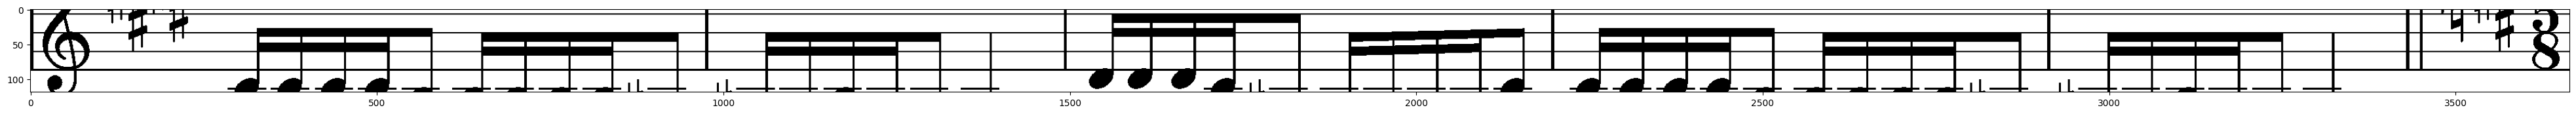

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(50, 30))
ax.imshow(staff_box.crop(s.img), cmap="Greys_r")

In [105]:
np.sum(row_black_pixel_sum[z[-1]], axis=1)

array([3747, 3808, 4691, 5145, 7328, 4512])

In [158]:
strict_candidates = np.where(row_black_pixel_sum > 0.7 * num_cols)[0]
candidates = np.sort(
    np.unique(
        np.concatenate(
            [strict_candidates + k for k in range(-s.line_width, s.line_width + 1, 7)]
        )
    ),
    kind="quicksort",
)

In [163]:
strict_candidates

array([ 384,  385,  411,  412,  437,  438,  439,  464,  465,  491,  492,
        666,  667,  693,  694,  719,  720,  721,  746,  747,  773,  774,
        948,  949,  974,  975,  976, 1001, 1002, 1028, 1029, 1055, 1056,
       1392, 1393, 1419, 1420, 1445, 1446, 1447, 1472, 1473, 1499, 1500,
       1674, 1675, 1700, 1701, 1702, 1727, 1728, 1754, 1755, 1781, 1782,
       1964, 1965, 1991, 1992, 2017, 2018, 2019, 2044, 2045, 2071, 2072,
       2408, 2409, 2435, 2436, 2462, 2463, 2488, 2489, 2490, 2515, 2516,
       2726, 2727, 2753, 2754, 2780, 2781, 2807, 2808, 2834, 2835, 3043,
       3044, 3070, 3071, 3097, 3098, 3124, 3125, 3151, 3152, 3487, 3488,
       3514, 3515, 3541, 3542, 3568, 3569, 3595, 3596, 3769, 3770, 3796,
       3797, 3823, 3824, 3850, 3851, 3877, 3878, 4081, 4082, 4108, 4109,
       4134, 4135, 4136, 4161, 4162, 4188, 4189, 4525, 4526, 4552, 4553,
       4579, 4580, 4605, 4606, 4607, 4632, 4633, 4807, 4808, 4834, 4835,
       4860, 4861, 4862, 4887, 4888, 4914, 4915, 51

In [159]:
candidates

array([ 382,  383,  409,  410,  435,  436,  437,  462,  463,  489,  490,
        664,  665,  691,  692,  717,  718,  719,  744,  745,  771,  772,
        946,  947,  972,  973,  974,  999, 1000, 1026, 1027, 1053, 1054,
       1390, 1391, 1417, 1418, 1443, 1444, 1445, 1470, 1471, 1497, 1498,
       1672, 1673, 1698, 1699, 1700, 1725, 1726, 1752, 1753, 1779, 1780,
       1962, 1963, 1989, 1990, 2015, 2016, 2017, 2042, 2043, 2069, 2070,
       2406, 2407, 2433, 2434, 2460, 2461, 2486, 2487, 2488, 2513, 2514,
       2724, 2725, 2751, 2752, 2778, 2779, 2805, 2806, 2832, 2833, 3041,
       3042, 3068, 3069, 3095, 3096, 3122, 3123, 3149, 3150, 3485, 3486,
       3512, 3513, 3539, 3540, 3566, 3567, 3593, 3594, 3767, 3768, 3794,
       3795, 3821, 3822, 3848, 3849, 3875, 3876, 4079, 4080, 4106, 4107,
       4132, 4133, 4134, 4159, 4160, 4186, 4187, 4523, 4524, 4550, 4551,
       4577, 4578, 4603, 4604, 4605, 4630, 4631, 4805, 4806, 4832, 4833,
       4858, 4859, 4860, 4885, 4886, 4912, 4913, 51

In [141]:
current_row = z[0]
[
    list(range(j, j + s.line_width))
    for j in range(
        current_row,
        current_row + (5 - 1) * (s.line_width + s.line_spacing) + 1,
        s.line_width + s.line_spacing,
    )
]

[[382, 383], [409, 410], [436, 437], [463, 464], [490, 491]]

In [142]:
row_black_pixel_sum[[[382, 383], [409, 410], [436, 437], [463, 464], [490, 491]]]

array([[  69,   71],
       [ 144,  145],
       [ 225, 3674],
       [ 196, 3664],
       [ 215, 3664]])

In [143]:
staff_lines = [
    row_black_pixel_sum[j : j + s.line_width]
    for j in range(
        current_row,
        current_row + (5 - 1) * (s.line_width + s.line_spacing) + 1,
        s.line_width + s.line_spacing,
    )
]
staff_lines

[array([69, 71]),
 array([144, 145]),
 array([ 225, 3674]),
 array([ 196, 3664]),
 array([ 215, 3664])]

In [135]:
num_stafflines = 5
num_rows = s.img.shape[0]
staff_length = num_stafflines * (s.line_width + s.line_spacing) - s.line_spacing
iter_range = num_rows - staff_length + 1

In [136]:
iter_range

5739

In [5]:
3 / 0.9

3.333333333333333

# Efficient col indices


In [7]:
utils.find_staffline_columns(
    s.img, s.all_staff_row_indices, s.line_width, s.line_spacing
)

[(273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938)]

In [ ]:
def find_staffline_columns(
    img, all_staffline_vertical_indices, line_width, line_spacing
):
    all_staff_extremes

In [5]:
s.img.shape

(5848, 4132)

In [99]:
binary_image = np.where(s.img == 0, 1, 0)
num_cols = s.img.shape[1]
staff_length = s.staff_length
all_staff_col_indices = []
for row_idx in s.all_staff_row_indices:
    staff = binary_image[row_idx[0][0] : row_idx[-1][-1], :]
    current_beginning = []
    current_ending = []
    for col in range(num_cols // 2):
        left = staff[:, col]
        right = staff[:, -col]
        num_rows = len(left)
        if np.sum(left) == 0:
            current_beginning.append(col)
        if np.sum(right) == 0:
            current_ending.append(num_cols - col)
    if current_beginning and current_ending:
        all_staff_col_indices.append(
            [np.max(current_beginning), np.min(current_ending)]
        )

In [100]:
all_staff_col_indices

[[273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938],
 [273, 3938]]

272

In [73]:
s.all_staff_col_indices

[(273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938),
 (273, 3938)]

In [48]:
binary_image = np.where(s.img == 255, 1, 0)
staff = binary_image[
    s.all_staff_row_indices[1][0][0] : s.all_staff_row_indices[1][-1][-1], :
]
col_data = staff[:, col]
run_starts = np.where(np.diff(col_data) == 1)[0] + 1
run_ends = np.where(np.diff(col_data) == -1)[0]

In [49]:
if col_data[0] == 1:
    run_starts = np.insert(run_starts, 0, 0)
if col_data[-1] == 1:
    run_ends = np.append(run_ends, len(col_data) - 1)

In [52]:
run_lengths = run_ends - run_starts + 1

In [57]:
np.all(run_lengths == len(col_data))

True

In [55]:
len(col_data)

109

In [ ]:
binary_image[:,]

In [75]:
s.all_staff_row_indices[1]

[[665, 666], [692, 693], [719, 720], [746, 747], [773, 774]]

In [89]:
s.img[665:774, 273]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255], dtype=uint8)

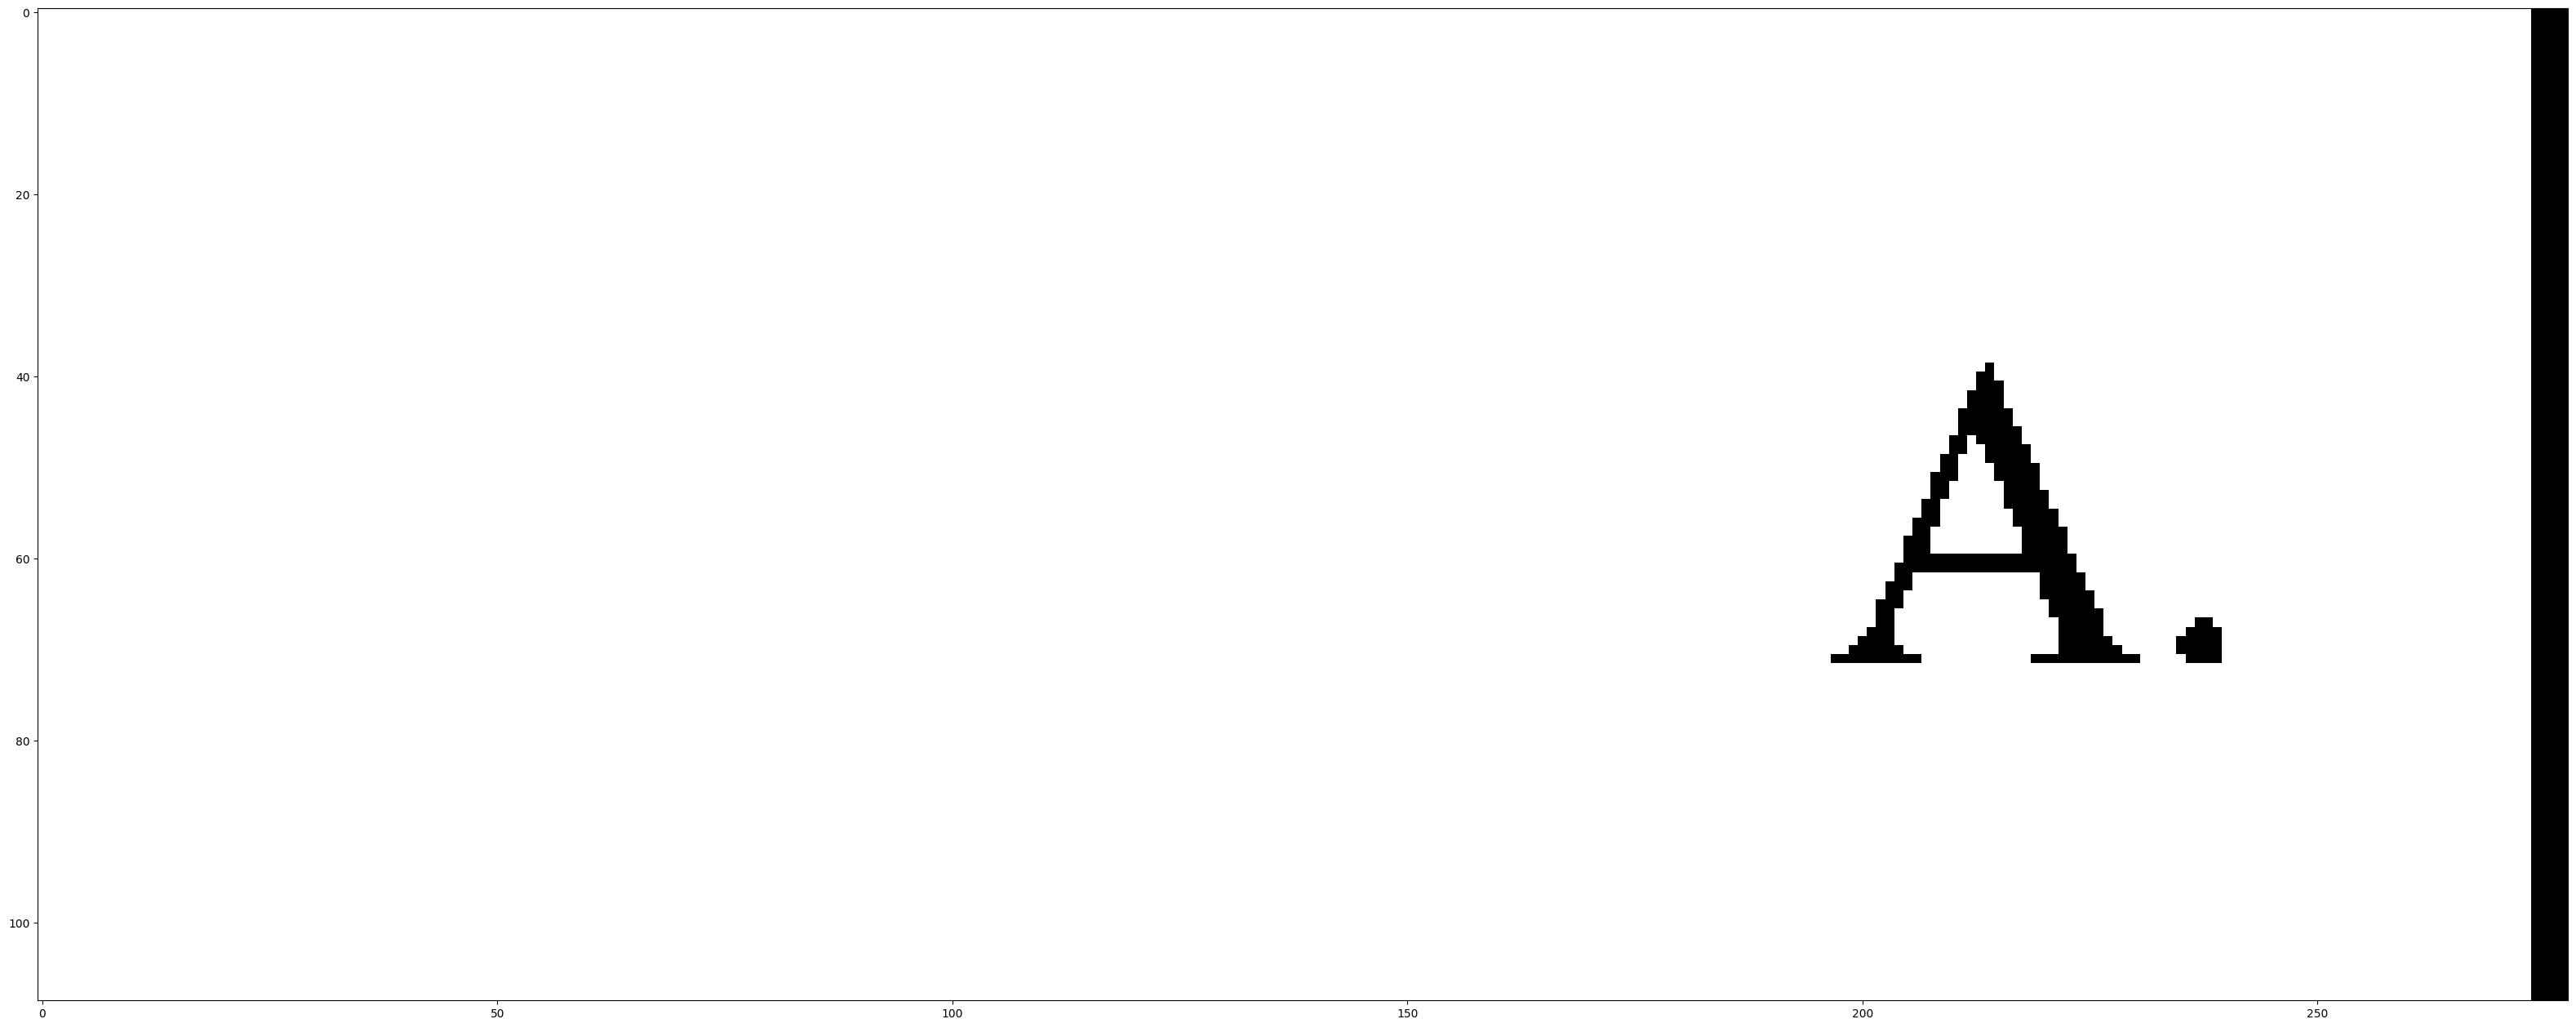

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(40, 20))
ax.imshow(s.img[665:774, :278], cmap="Greys_r")

# other optim


In [14]:
a = time.time()
for i in range(100000):
    continue
checkpoint = time.time() - a
seconds = int(checkpoint)
microseconds = int((checkpoint - seconds) * 1e6)
print(f"{seconds} s : {microseconds} ms")

0 s : 2339 ms
